In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
data, info =tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [ ]:
class_names=info.features['label'].names

In [ ]:
class_names

['neg', 'pos']

In [ ]:
training_sentences=[]
training_labels=[]
for text, label in data['train']:
  training_sentences.append(text.numpy().decode())
  training_labels.append(label.numpy())

testing_sentences=[]
testing_labels=[]
for text, label in data['test']:
  testing_sentences.append(text.numpy().decode())
  testing_labels.append(label.numpy())

In [ ]:
training_labels=np.array(training_labels)
testing_labels=np.array(testing_labels)

In [ ]:
len(testing_labels)

25000

In [ ]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-_gn1kl01
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-_gn1kl01
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7621 sha256=d5d2d94ca7f287bb96328589e01b3c0f03a30e0b06a512c8b5db9f8dc6a14c4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-j9bxp7ev/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [ ]:
import preprocess_kgptalkie as ps
import re

def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [ ]:
training_sentences = [get_clean(x) for x in training_sentences]
testing_sentences = [get_clean(x) for x in testing_sentences]

/usr/local/lib/python3.10/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [ ]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
vocab_size=50000
input_length=1000
tokenizer=Tokenizer(num_words=vocab_size,oov_token='<OOV>')
tokenizer.fit_on_texts(training_sentences)
training_sequences=tokenizer.texts_to_sequences(training_sentences)
training_padded=pad_sequences(training_sequences, maxlen=input_length,padding='post',truncating='post')
testing_sequences=tokenizer.texts_to_sequences(testing_sentences)
testing_padded=pad_sequences(testing_sequences, maxlen=input_length, padding='post', truncating='post')

In [ ]:
vocab_dic=tokenizer.word_index


In [ ]:
input_length

1000

In [ ]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense,Conv1D, GlobalAveragePooling1D, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
model=Sequential()
model.add(Embedding(vocab_size,64,input_length=input_length))
model.add(Conv1D(64,3,activation='relu'))
model.add(Conv1D(128,3,activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history=model.fit(training_padded,training_labels,epochs=4,validation_data=(testing_padded,testing_labels))

Epoch 1/4
782/782 [==============================] - 89s 112ms/step - loss: 0.6682 - accuracy: 0.5872 - val_loss: 0.5230 - val_accuracy: 0.8008
Epoch 2/4
782/782 [==============================] - 46s 58ms/step - loss: 0.3531 - accuracy: 0.8675 - val_loss: 0.3373 - val_accuracy: 0.8668
Epoch 3/4
782/782 [==============================] - 29s 36ms/step - loss: 0.2384 - accuracy: 0.9123 - val_loss: 0.3011 - val_accuracy: 0.8811
Epoch 4/4
782/782 [==============================] - 21s 27ms/step - loss: 0.1837 - accuracy: 0.9343 - val_loss: 0.3004 - val_accuracy: 0.8836


In [ ]:
import matplotlib.pyplot as plt

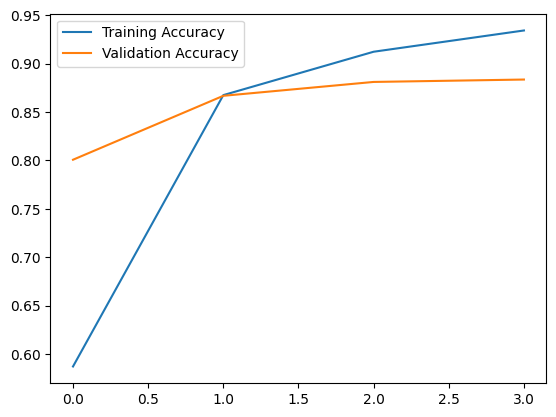

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
import pickle
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))
model.save('imdb_sent_analysis.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

In [ ]:
model1=load_model('imdb_sent_analysis.h5')
token1=pickle.load(open('tokenizer.pkl','rb'))

In [ ]:
reviews = [
    "I absolutely loved this movie! The acting was fantastic, and the plot was engaging.",
    "The film was a bit disappointing. It had some good moments, but it didn't meet my expectations.",
    "This movie is a masterpiece. The performances by the cast were outstanding, and the storyline was brilliantly crafted.",
    "I found the movie to be just average. It had its moments, but overall, it didn't leave a strong impression.",
    "An incredible cinematic experience! The actors delivered remarkable performances, and the direction was superb.",
    "The movie was a letdown. I expected more from it, but it fell short in terms of storytelling and character development.",
    "A must-watch film! The acting was phenomenal, and the emotional depth of the story was truly captivating.",
    "I wasn't too impressed with the movie. It had potential, but it didn't quite deliver on its promise.",
    "This is one of the best movies I've ever seen. The acting, direction, and writing were all exceptional.",
    "The movie had its moments, but it lacked consistency. Some scenes were great, while others felt forced.",
    "Great film, I thoroughly enjoyed it!",
    "It was an okay movie, nothing too special.",
    "Not a fan of this one. The plot was confusing, and the characters were poorly developed.",
    "I couldn't make sense of the storyline. It was all over the place.",
    "I guess some people might like it, but it's definitely not my cup of tea.",
    "I'm still trying to figure out what the director was thinking with this one.",
    "Wow, what a fantastic movie NOT! It was a complete waste of my time.",
    "The performances were so awful; it's almost impressive.",
    "I couldn't stop yawning throughout the film. It was THAT exciting.",
    "This movie is definitely NOT a classic. Don't believe the hype.",
    "I absolutely loved this movie NOT! The acting was terrible, and the plot was boring.",
    "The film was a bit disappointing, NOT. It had some good moments, NOT, but it didn't meet my expectations, NOT.",
    "This movie is a masterpiece NOT. The performances by the cast were terrible, and the storyline was poorly crafted.",
    "I found the movie to be just average, NOT. It had its moments, NOT, but overall, it didn't leave a strong impression, NOT.",
    "An incredible cinematic experience NOT! The actors delivered terrible performances, and the direction was awful.",
    "The movie was a letdown, NOT! I expected more from it, NOT, but it fell short in terms of storytelling and character development, NOT.",
    "A must-watch film NOT! The acting was phenomenal, NOT, and the emotional depth of the story was truly captivating, NOT.",
    "I wasn't too impressed with the movie, NOT. It had potential, NOT, but it didn't quite deliver on its promise, NOT.",
]





reviews=[get_clean(x) for x in reviews]
new_seqs=token1.texts_to_sequences(reviews)
new_pad=pad_sequences(new_seqs,maxlen=input_length,padding='post',truncating='post')
pred=model1.predict(new_pad )

1/1 [==============================] - 0s 109ms/step


In [ ]:
[class_names[int(x[0])]for x in pred>0.5]

['pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'neg',
 'pos',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg']

In [ ]:
def analyse_sent(x):
  if x>=0.6:
    return "Very Positive"
  if x<=0.4:
    return "Very Negative"
  if x>=0.525 and x<0.6:
    return "Positive"
  if x<=0.475 and x>0.4:
    return "Negative"
  if x<0.525 and x>0.475:
    return "Neutral"

In [ ]:
pred1=[analyse_sent(rev) for rev in pred]

In [ ]:
pred1

['Positive',
 'Very Negative',
 'Very Positive',
 'Negative',
 'Very Positive',
 'Negative',
 'Positive',
 'Very Negative',
 'Positive',
 'Neutral',
 'Very Positive',
 'Very Negative',
 'Very Negative',
 'Very Negative',
 'Neutral',
 'Very Negative',
 'Very Negative',
 'Very Negative',
 'Neutral',
 'Neutral',
 'Very Negative',
 'Very Negative',
 'Very Negative',
 'Very Negative',
 'Very Negative',
 'Very Negative',
 'Negative',
 'Very Negative']